In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import json
import seaborn as sns
from scipy.linalg import sqrtm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

%matplotlib inline
mpl.rcParams['figure.figsize'] = 18, 7
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Finding Mature Content in Twitch Graph with Label Propagation

## Tell me who your friends are

There's this famous saying - "Tell me who your friends are, and I will tell you who you are". Not sure how generalisable this statement is but it is useful in explaining label propagation. Let's say that I have 4 friends - 2 from university and 2 from work.

[]

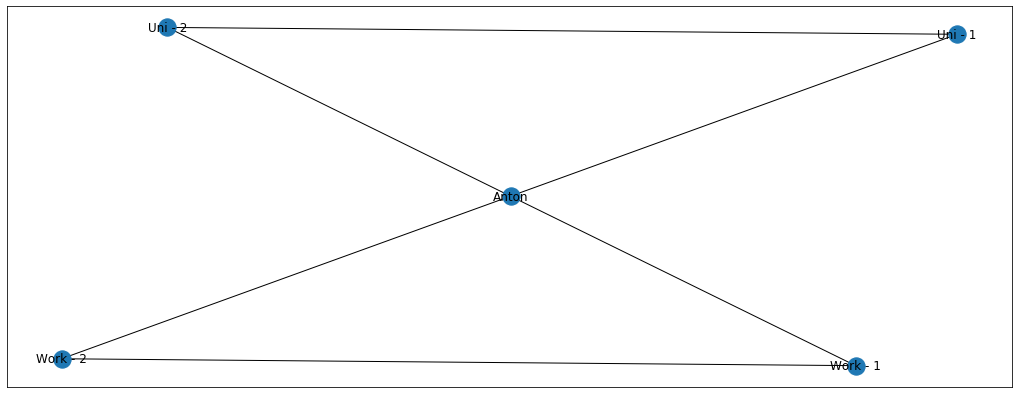

In [314]:
G = nx.Graph()
G.add_edge('Uni - 1', 'Anton')
G.add_edge('Anton', 'Work - 1')
G.add_edge('Uni - 1', 'Uni - 2')
G.add_edge('Uni - 2', 'Anton')
G.add_edge('Work - 1', 'Work - 2')
G.add_edge('Anton', 'Work - 2')

pos = nx.spring_layout(G, seed=42) # to keep the layout consistent
nx.draw_networkx(G, pos=pos)

plt.plot()

Imagine now that my friends from university and from work are giant football fans and talk about it all the time. I, on the other hand, am still undecided whether I like the game or not. Let's denote **football = blue** and **undecided = grey**

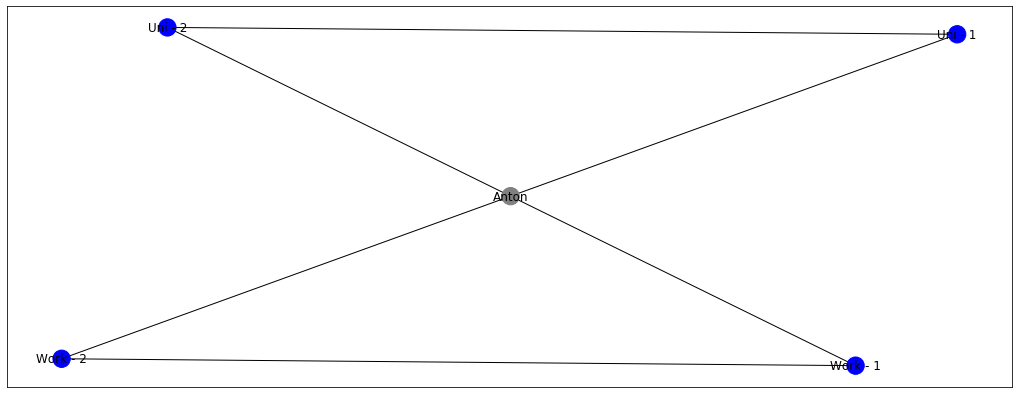

In [332]:
labels_dict = {'Uni - 1': 'blue',
              'Uni - 2': 'blue',
              'Work - 1': 'blue',
              'Work - 2': 'blue',
              'Anton': 'grey'}


init_colors = [labels_dict[i] for i in list(G.nodes)]
nx.draw_networkx(G, pos=pos, node_color=init_colors)

Just by looking at this graph, it becomes logical that node Anton should also be colored blue! This is exactly the idea of label propagation - if everyone in my surrounding likes footbal, I'm very likely to like it as well. Which makes intuitive sense, right? My colleagues and friends are going to discuss it all the time, watch games togethers, and play it themselves. At some point, I'm likely to give in and just join a game or two, until I become a massive fan myself. But let's say, that my colleagues from work still like the footbal, but my friends from university now started to enjoy boxing more. Let's denote **boxing = red**

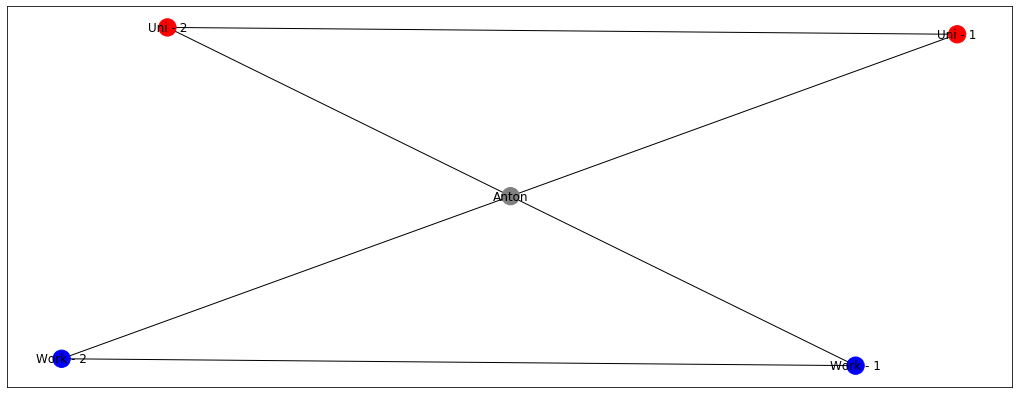

In [333]:
labels_dict = {'Uni - 1': 'red',
              'Uni - 2': 'red',
              'Work - 1': 'blue',
              'Work - 2': 'blue',
              'Anton': 'grey'}

init_colors = [labels_dict[i] for i in list(G.nodes)]
nx.draw_networkx(G, pos=pos, node_color=init_colors)

Now it's more challenging, right? Will my node become blue or red? Well, probably something in the middle because I want to part of the both of the groups. Label propagation algortihms ensure that the labels of your surrounding are sort of averaged and the node Anton gets something of a magenta color. 

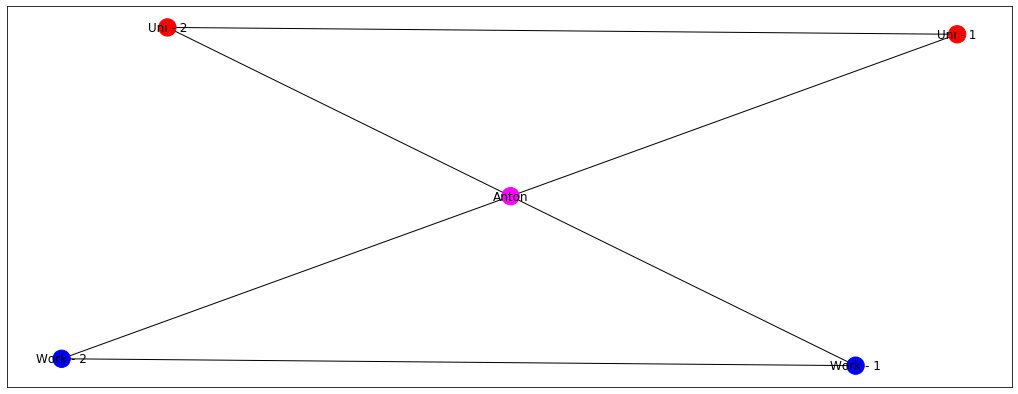

In [334]:
labels_dict = {'Uni - 1': 'red',
              'Uni - 2': 'red',
              'Work - 1': 'blue',
              'Work - 2': 'blue',
              'Anton': 'magenta'}

init_colors = [labels_dict[i] for i in list(G.nodes)]
nx.draw_networkx(G, pos=pos, node_color=init_colors)

Now that we have an intuitive understanding of label propagation, let's start working with a larger graph.

## Data

First, I'm going to generate a random graph that will serve as our dataset for this tutorial.

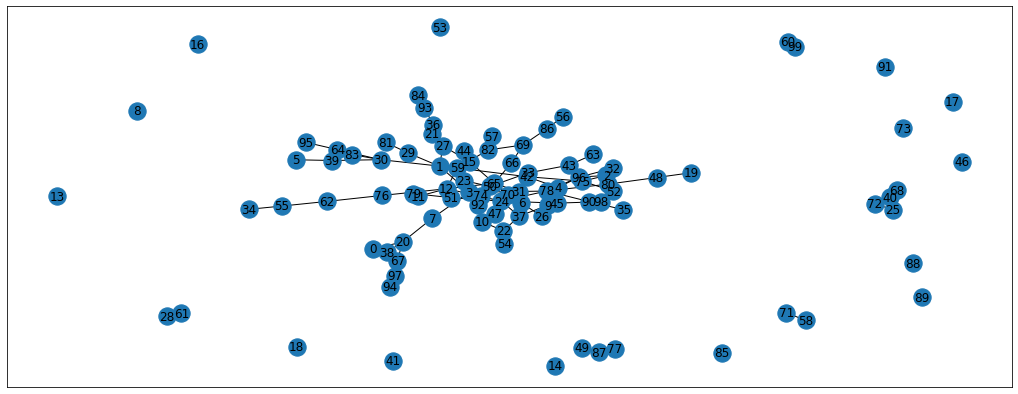

In [335]:
G = nx.gnp_random_graph(100, 0.02, seed=42) # Graph size = 100, probability that 2 nodes are connected - 2%
pos = nx.spring_layout(G, seed=42) # To be able to recreate the graph layout
nx.draw_networkx(G, pos=pos) # Plot the graph

Cool, we now have 1 large graph and some nodes that are not connected. Let's delete these unconnected nodes, as there's no way to propagate the information to them (at least without any additional data)

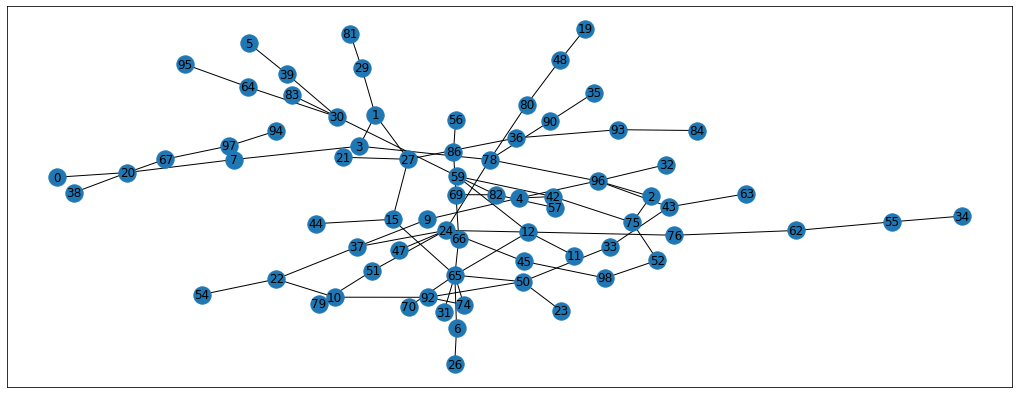

In [344]:
subgraph_nodes = list(nx.dfs_preorder_nodes(G, 7)) #Gets all the nodes in the graph that node 7 belongs to. 
G = G.subgraph(subgraph_nodes)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, cmap='coolwarm')

Much better! This graph is absolutely random, so there's no labels associated with it. Manually, I'm going to pick 10 nodes, and I will label them as 1 if they come from the right side of the graph and -1 if from the left side. This way, we're going to have some of the nodes labelled and we'll see the label propagation in action. 

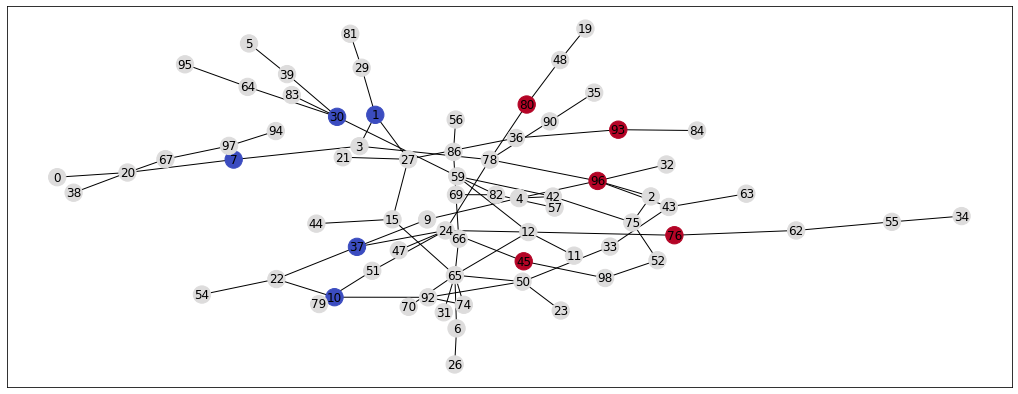

In [648]:
known_nodes = np.array([76, 96, 80, 93, 45, 37, 10, 1, 7, 30]) #picked more or less randomly
unknown_nodes = np.array([n for n in G.nodes if n not in known_nodes])

known_y = np.array([1, 1, 1, 1, 1, -1, -1, -1, -1, -1])
unknown_y = np.array([0 for i in range(len(unknown_nodes))])

init_labels = dict(zip(np.append(known_nodes, unknown_nodes), np.append(known_y,unknown_y)))
init_colors = [init_labels[i] for i in list(G.nodes)]
nx.draw_networkx(G, pos=pos, node_color=init_colors, cmap='coolwarm')

Given this set of label, nodes, and edges, our task is to assign some sort of label to the unlabelled nodes. In other words, **given that we know what some of the people in the network like (e.g. football or boxing) and with whom they are friends, we need to guess whether their friends better prefer footbal or boxing.** To answer this question, I'm going to explain this [Label Propagation algorithm](https://www.semanticscholar.org/paper/Learning-from-labeled-and-unlabeled-data-with-label-Zhu-Ghahramani/2a4ca461fa847e8433bab67e7bfe4620371c1f77) (Zhu 2002). 

## Label Propagation - Zhu (2002)

To understand what this algorithm does, I need to introduce a new concepts - Adjacency Matrix. Adjacency matrix simply says to which nodes each node is connected. It's a way to represent a graph using data structures that can be used in computations. We can get an adjacency matrix for our graph using `networkx` functions

In [649]:
A = np.array(nx.adj_matrix(G).todense())
A_df = pd.DataFrame(A, index=G.nodes(), columns=G.nodes())
A_df.head()

,0,1,2,3,4,5,6,7,9,10,...,84,86,90,92,93,94,95,96,97,98
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


Using this matrix we can check which nodes are connected via the edges. For example, let's see to which nodes the node 29 is connected. If you look at the graph, it should be connected to the nodes 81 and 1

In [650]:
A_df.loc[29, :][A_df.loc[29, :]  == 1]
#Expected output:
# 1     1
# 81    1
# Name: 29, dtype: int64

1     1
81    1
Name: 29, dtype: int64

As expected, the row 29 has connections to only columns 81 and 1. Having this matrix representation of the graph we can do so much more! For example, we can calculate the degree matrix i.e. to how many nodes each node is connected. Also, we can calculate the transition matrix which in our friends network analogy can mean - what's the probability that a particular person is going to talk to another person in this network? We can build it like so

In [651]:
T = np.matrix(A / A.sum(axis=1, keepdims=True))
T_df = pd.DataFrame(T, index=G.nodes(), columns=G.nodes())
T_df.loc[29, :][T_df.loc[29, :]  != 0]
#Expected output:
# 1    0.50000
# 81   0.50000
# Name: 29, dtype: float64

1    0.50000
81   0.50000
Name: 29, dtype: float64

Here we can see that because node 29 was connected to nodes 1 and 81, they both get probability of 50%. We could alter this with some kind of connection weights to make some connections more probable than another. E.g. if I talked to my friends from work more frequently, I'd want the graph to represent this as well, to ensure that the labels get propagated accordingly. 

And that's basocially all the prep for for this algorithm. The actual algorithm can be described in these steps:
1. Order your nodes in a way, that the nodes with known labels are first
2. Calculate the adjacency matrix 
3. Calculate transition matrix
4. Make known nodes absorbing:
    * Set probability of going from known node to the same known node as 1
    * Set all the other probabilities as 0
    * This way, the probability of going from e.g. node 1 to node 1 is 100%
5. Update the labels by multiplying the known labels with the resulting transition matrix
6. Repeat until the labels stop changing

Here's the code that implements these steps for you and feel free to read the paper for better intuition on why it works. 

In [15]:
def label_propagation(G, Y_init, known_nodes, unknown_nodes, threshold=0.01):
    # Step 1: order nodes
    ordered_nodes = list(known_nodes) + list(unknown_nodes) 
    
    # Step 2: adjacency matrix
    A = nx.adj_matrix(G, nodelist=ordered_nodes) 
    A = A.todense()
    A = np.array(A, dtype = np.float64)
    
    # Step 3: transition matrix
    T = A / A.sum(axis=1, keepdims=True)
    
    # Step 4: absorbing nodes
    T[:len(known_nodes), :] = 0
    T[:len(known_nodes), :len(known_nodes)] = np.identity(len(known_nodes)) 
    
    #Step 5 & 6: update labels until convergence
    labels = [Y_init] #stores the label progression for the animation
    Y1 = Y_init 
    for i in tqdm(range(1000)):
        Y0 = Y1
        Y1 = np.dot(T, Y0) #The actual probability update is happening here. 
        diff = np.abs(Y0 - Y1).sum() #calculate the difference between Y(t-1) and Y(t)
        Y1[:len(known_nodes)] = Y_init[:len(known_nodes)] #set the known labels back to their initial values
        labels.append(Y1)
        if i % 10 == 0:
            print('Total difference:', diff)
        if diff < threshold: #stopping criterion
            break
    
    return labels

With the algorithm defined, let's run it and see the results. 

In [653]:
Y_init = np.append(known_y, unknown_y) #remember, the known labels (nodes) should always go first

In [654]:
labels = label_propagation(G, Y_init, known_nodes, unknown_nodes, threshold=0.01) #run the algorithm

  8%|▊         | 82/1000 [00:00<00:00, 15223.66it/s]

Total difference: 11.183333333333334
Total difference: 1.1102982053367352
Total difference: 0.4557170878486895
Total difference: 0.2317372035531982
Total difference: 0.12366531606432361
Total difference: 0.06722651043228016
Total difference: 0.03685108906325815
Total difference: 0.02028339262096708
Total difference: 0.011189249412098229


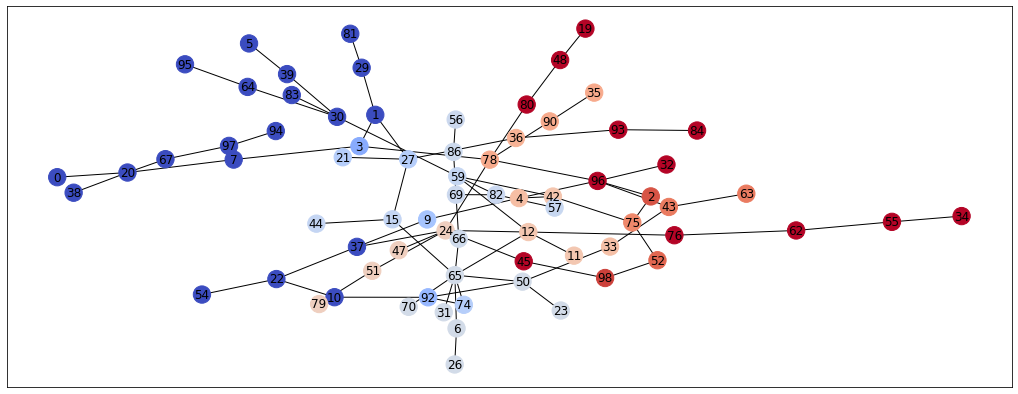

In [655]:
propagated_labels = dict(zip(np.append(known_nodes, unknown_nodes), labels[-1])) #create a dictionary node:label
propagated_colors = [propagated_labels[i] for i in list(G.nodes)] #color intensity for visualisation
nx.draw_networkx(G, pos=pos, node_color=propagated_colors,  cmap='coolwarm')

As you can see, the right hand side is noticeably more red which indicates that they have larger propagated labels. This is exactly what we'd expect from this algorithm, so we can say that it was successful in its task. 

In [12]:
# # To generate the gif

# from matplotlib import animation

# fig, ax = plt.subplots(figsize=(18, 7))

# def update(idx):
#     ax.clear()
#     propagated_labels = dict(zip(np.append(known_nodes, unknown_nodes), labels[idx])) #create a dictionary node:label
#     propagated_colors = [propagated_labels[i] for i in list(G.nodes)] #color intensity for visualisation
#     nx.draw(G, pos, node_color=propagated_colors, ax=ax, cmap='coolwarm')
#     ax.set_title(f"Iter={idx}", fontsize=20)

# anim = animation.FuncAnimation(fig, update, frames=len(labels), interval=200, repeat=True)

# anim.save(
#     'label_propagation.gif', 
#     dpi=600, bitrate=-1,
#     savefig_kwargs={'transparent': True, 'facecolor': 'none'},
# )

## Twitch Dataset

In [4]:
edges_path = 'datasets-master/twitch/ENGB/ENGB_edges.csv'
targets_path = 'datasets-master/twitch/ENGB/ENGB_target.csv'
features_path = 'datasets-master/twitch/ENGB/ENGB_features.json'

In [5]:
edges = pd.read_csv(edges_path)
edges.head()

,from,to
0,6194,255
1,6194,980
2,6194,2992
3,6194,2507
4,6194,986


In [6]:
targets = pd.read_csv(targets_path)
targets.index = targets.new_id
targets.head()

,id,days,mature,views,partner,new_id
new_id,,,,,,
2299,73045350,1459,False,9528,False,2299
153,61573865,1629,True,3615,False,153
397,171688860,411,True,46546,False,397
5623,117338954,953,True,5863,False,5623
5875,135804217,741,True,5594,False,5875


In [10]:
# Reading the json as a dict
with open(features_path) as json_data:
    features = json.load(json_data)

max_feature = np.max([v for v_list in features.values() for v in v_list])
features_matrix = np.zeros(shape = (len(list(features.keys())), max_feature+1))
print(features_matrix.shape)

i = 0
for k, vs in features.items():
    for v in vs:
        features_matrix[i, v] = 1
    i+=1



(7126, 3170)


In [11]:
# labels in correct order
y = targets.loc[[int(i) for i in list(features.keys())], 'mature']

## Label Propagation on Twitch Dataset

In [13]:
graph = nx.convert_matrix.from_pandas_edgelist(edges, "from", "to")

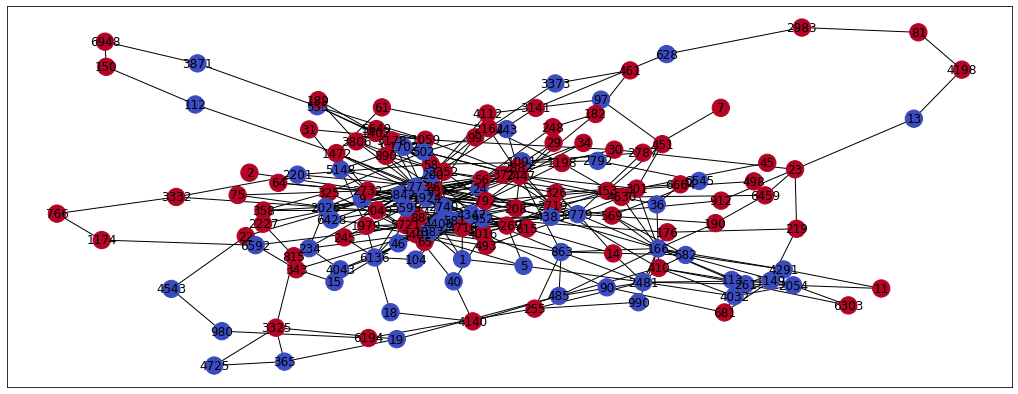

In [28]:
#Subgraph
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, 7))[:150] #Gets all the nodes in the graph that node 7 belongs to. 
G = graph.subgraph(subgraph_nodes)
pos = nx.spring_layout(G, seed=42)
colors = [targets.loc[n, 'mature'] for n in G.nodes]
nx.draw_networkx(G, pos=pos, cmap='coolwarm', node_color = colors)

### Train Size: 80%

In [32]:
print('80% train, 20% test')
lp_aucs = []
for i in range(100):
    known = y.sample(n=int(0.8 * len(y)))
    known_nodes = known.index.values

    unknown = y[~y.index.isin(known.index)]
    unknown_nodes = unknown.index.values

    Y_init = [1 if y == True else 0 for y in known] + [0 for y in unknown]
    labels = label_propagation(graph, Y_init, known_nodes, unknown_nodes)
    
    lp_aucs.append(roc_auc_score(unknown.values, labels[-1][len(known_nodes):]))

print('Label Propagation Mean AUC:', np.mean(lp_aucs))
print('Label Propagation Std AUC:', np.std(lp_aucs))

rf_aucs = []
for i in tqdm(range(100)):
    X_train, X_test, y_train, y_test = train_test_split(features_matrix, y, test_size = 0.2)
    rf = RandomForestClassifier(n_estimators=50)
    rf.fit(X_train, y_train)
    y_preds = rf.predict_proba(X_test)
    rf_aucs.append(roc_auc_score(y_test, y_preds[:, 1]))

80% train, 20% test


  1%|▏         | 13/1000 [00:00<00:13, 73.31it/s]


Total difference: 640.4179692676478
Total difference: 0.03131361714884769


  2%|▏         | 15/1000 [00:00<00:12, 76.76it/s]


Total difference: 622.5254061245764
Total difference: 0.06952567092408724


  2%|▏         | 16/1000 [00:00<00:12, 78.44it/s]

Total difference: 614.0834271527066
Total difference: 0.06068452820638569



  1%|▏         | 13/1000 [00:00<00:13, 71.96it/s]


Total difference: 637.0092438850672
Total difference: 0.030994894370730774


  1%|▏         | 13/1000 [00:00<00:13, 74.01it/s]


Total difference: 663.8126618550307
Total difference: 0.02878444384499179


  1%|          | 12/1000 [00:00<00:11, 84.53it/s]


Total difference: 625.4467769088874
Total difference: 0.025165042911155948


  1%|▏         | 14/1000 [00:00<00:13, 75.49it/s]


Total difference: 641.3146528088689
Total difference: 0.05299601386167403


  2%|▏         | 16/1000 [00:00<00:11, 86.06it/s]


Total difference: 619.6336690181938
Total difference: 0.0780789653702782


  2%|▏         | 16/1000 [00:00<00:11, 87.01it/s]


Total difference: 628.7450794284994
Total difference: 0.09042355245872677


  2%|▏         | 16/1000 [00:00<00:11, 83.00it/s]


Total difference: 631.7880576187492
Total difference: 0.06834430495633136


  1%|▏         | 14/1000 [00:00<00:11, 85.23it/s]


Total difference: 667.6623252212758
Total difference: 0.043308761867592235


  1%|▏         | 14/1000 [00:00<00:11, 85.77it/s]


Total difference: 616.1262076711952
Total difference: 0.04697350866395254


  1%|          | 12/1000 [00:00<00:11, 82.75it/s]


Total difference: 622.9193117029901
Total difference: 0.025827698705605508


  1%|▏         | 13/1000 [00:00<00:14, 67.28it/s]


Total difference: 657.3686768516934
Total difference: 0.02506431006864731


  1%|▏         | 13/1000 [00:00<00:11, 82.65it/s]


Total difference: 651.2565653438016
Total difference: 0.030131081881774775


  1%|▏         | 14/1000 [00:00<00:13, 74.85it/s]


Total difference: 640.8955301617374
Total difference: 0.03942516552170684


  1%|          | 12/1000 [00:00<00:14, 70.36it/s]


Total difference: 612.9565848827856
Total difference: 0.022470648545315237


  1%|▏         | 14/1000 [00:00<00:11, 89.58it/s]


Total difference: 644.5298127728468
Total difference: 0.0335023570683409


  1%|▏         | 14/1000 [00:00<00:11, 87.22it/s]


Total difference: 617.2808053961654
Total difference: 0.04226124080487336


  1%|▏         | 14/1000 [00:00<00:11, 85.41it/s]


Total difference: 618.3348229520407
Total difference: 0.04683534651880827


  2%|▏         | 19/1000 [00:00<00:10, 89.38it/s]

Total difference: 638.5104817555124
Total difference: 0.12118993049653247



  1%|▏         | 14/1000 [00:00<00:11, 84.94it/s]


Total difference: 637.2833303298229
Total difference: 0.05416716863459476


  2%|▏         | 17/1000 [00:00<00:11, 85.89it/s]


Total difference: 622.0532172620424
Total difference: 0.08465046134820625


  1%|▏         | 13/1000 [00:00<00:11, 87.33it/s]


Total difference: 638.0884070285956
Total difference: 0.028489403573075153


  1%|          | 11/1000 [00:00<00:13, 74.11it/s]


Total difference: 637.5875079853629
Total difference: 0.016302372022358104


  1%|▏         | 13/1000 [00:00<00:13, 74.36it/s]


Total difference: 629.1611212031319
Total difference: 0.035481553287019914


  1%|▏         | 14/1000 [00:00<00:11, 84.78it/s]


Total difference: 614.7536699764187
Total difference: 0.046996541353647184


  1%|▏         | 14/1000 [00:00<00:11, 89.05it/s]


Total difference: 609.1260813679197
Total difference: 0.04551111390159889


  1%|▏         | 14/1000 [00:00<00:11, 89.21it/s]


Total difference: 631.6275448202543
Total difference: 0.03599118512291659


  2%|▏         | 16/1000 [00:00<00:10, 89.94it/s]


Total difference: 644.7598404473895
Total difference: 0.06209325554216451


  1%|▏         | 13/1000 [00:00<00:11, 87.93it/s]


Total difference: 588.5553448958029
Total difference: 0.031085712051109705


  1%|▏         | 13/1000 [00:00<00:11, 82.39it/s]


Total difference: 646.41563190132
Total difference: 0.04176925084279108


  1%|          | 12/1000 [00:00<00:11, 86.57it/s]


Total difference: 622.9790365702519
Total difference: 0.01847925816949561


  1%|          | 12/1000 [00:00<00:11, 82.41it/s]


Total difference: 635.4191026561043
Total difference: 0.02120309342256254


  2%|▏         | 20/1000 [00:00<00:10, 95.80it/s]

Total difference: 640.541830705681
Total difference: 0.12411635686171672


  3%|▎         | 26/1000 [00:00<00:10, 93.33it/s]


Total difference: 0.02077893957019448


  1%|▏         | 14/1000 [00:00<00:11, 88.90it/s]


Total difference: 639.4762022751065
Total difference: 0.049540207016304225


  2%|▏         | 18/1000 [00:00<00:11, 88.01it/s]

Total difference: 629.6455637440356
Total difference: 0.21231225835004058


  2%|▏         | 21/1000 [00:00<00:11, 83.79it/s]


Total difference: 0.022316214231773115


  1%|▏         | 14/1000 [00:00<00:12, 80.93it/s]


Total difference: 621.966938845385
Total difference: 0.030630741130211664


  1%|▏         | 14/1000 [00:00<00:11, 82.42it/s]


Total difference: 666.55611764187
Total difference: 0.05345648141191321


  2%|▏         | 16/1000 [00:00<00:11, 84.49it/s]


Total difference: 640.1542278476795
Total difference: 0.08845407620024406


  1%|▏         | 13/1000 [00:00<00:12, 78.56it/s]


Total difference: 631.0427956265518
Total difference: 0.03675571108606936


  1%|▏         | 14/1000 [00:00<00:11, 87.50it/s]


Total difference: 656.1616197475976
Total difference: 0.04183075699640643


  1%|          | 12/1000 [00:00<00:11, 82.85it/s]


Total difference: 632.3026451361743
Total difference: 0.016308270342686934


  2%|▏         | 20/1000 [00:00<00:10, 91.58it/s]

Total difference: 634.538208245943
Total difference: 0.16570528085729816


  2%|▎         | 25/1000 [00:00<00:11, 88.29it/s]


Total difference: 0.029745756384510862


  2%|▏         | 18/1000 [00:00<00:11, 86.95it/s]

Total difference: 644.0721235333239
Total difference: 0.09064945099603908


  1%|▏         | 13/1000 [00:00<00:11, 84.23it/s]


Total difference: 637.2578125926216
Total difference: 0.03290280806503991


  2%|▏         | 19/1000 [00:00<00:10, 92.89it/s]

Total difference: 624.792892187681
Total difference: 0.1118933371495362


  2%|▏         | 20/1000 [00:00<00:11, 86.09it/s]


Total difference: 0.00730381729755529


  1%|          | 11/1000 [00:00<00:12, 81.28it/s]


Total difference: 635.8842195678426
Total difference: 0.012460126030288477


  1%|          | 10/1000 [00:00<00:12, 76.91it/s]


Total difference: 654.1789586238004
Total difference: 0.009769249665579807


  2%|▏         | 15/1000 [00:00<00:11, 87.20it/s]


Total difference: 631.3536263724698
Total difference: 0.08967927449965374


  1%|▏         | 14/1000 [00:00<00:11, 86.91it/s]


Total difference: 621.7647874306758
Total difference: 0.04443158823905638


  2%|▏         | 16/1000 [00:00<00:11, 88.62it/s]


Total difference: 614.3446083784501
Total difference: 0.07687908114811236


  1%|          | 12/1000 [00:00<00:11, 89.10it/s]


Total difference: 635.8032846068768
Total difference: 0.015548743849805646


  1%|          | 12/1000 [00:00<00:11, 86.82it/s]


Total difference: 653.6407973911164
Total difference: 0.02245691403489248


  2%|▏         | 17/1000 [00:00<00:10, 90.86it/s]


Total difference: 638.4860705372829
Total difference: 0.09507736990782037


  2%|▏         | 16/1000 [00:00<00:10, 90.88it/s]


Total difference: 628.6465854668563
Total difference: 0.0664541711738868


  1%|▏         | 13/1000 [00:00<00:12, 81.80it/s]


Total difference: 606.2519872001801
Total difference: 0.03889272733839309


  2%|▏         | 16/1000 [00:00<00:10, 91.05it/s]


Total difference: 637.6137533279799
Total difference: 0.06372061711604066


  1%|▏         | 14/1000 [00:00<00:11, 89.62it/s]


Total difference: 625.8579029256259
Total difference: 0.04775494019140562


  2%|▏         | 15/1000 [00:00<00:10, 90.03it/s]


Total difference: 645.05086836288
Total difference: 0.05470086329266357


  1%|▏         | 14/1000 [00:00<00:10, 90.02it/s]


Total difference: 630.2676229613392
Total difference: 0.03991497010330301


  2%|▏         | 16/1000 [00:00<00:10, 91.22it/s]


Total difference: 613.4777001257735
Total difference: 0.05837949928613291


  1%|▏         | 14/1000 [00:00<00:11, 88.87it/s]


Total difference: 604.1330705163966
Total difference: 0.043538390983275686


  2%|▏         | 17/1000 [00:00<00:10, 91.62it/s]


Total difference: 621.2758631872891
Total difference: 0.10095581765702637


  1%|▏         | 14/1000 [00:00<00:11, 88.60it/s]


Total difference: 622.1152812487783
Total difference: 0.039591078727507154


  2%|▏         | 15/1000 [00:00<00:10, 90.09it/s]


Total difference: 642.2329300770539
Total difference: 0.06131179694713572


  1%|▏         | 14/1000 [00:00<00:11, 88.63it/s]


Total difference: 640.4055196508514
Total difference: 0.0392305416568528


  2%|▏         | 15/1000 [00:00<00:10, 90.25it/s]


Total difference: 646.5362056729696
Total difference: 0.07335552471601944


  1%|▏         | 14/1000 [00:00<00:10, 90.18it/s]


Total difference: 636.7363036689399
Total difference: 0.04073894934062186


  1%|▏         | 13/1000 [00:00<00:11, 87.86it/s]


Total difference: 604.455550818012
Total difference: 0.0342952563285249


  1%|▏         | 13/1000 [00:00<00:11, 88.63it/s]


Total difference: 653.335986699577
Total difference: 0.03494351924398181


  1%|▏         | 13/1000 [00:00<00:11, 87.59it/s]


Total difference: 639.8257332679036
Total difference: 0.026490211047399057


  1%|          | 12/1000 [00:00<00:11, 88.76it/s]


Total difference: 625.4934769151068
Total difference: 0.0222602711312304


  2%|▏         | 18/1000 [00:00<00:10, 91.56it/s]


Total difference: 638.2344623923873
Total difference: 0.09832186679961571


  2%|▏         | 17/1000 [00:00<00:10, 91.25it/s]


Total difference: 581.9980383139795
Total difference: 0.0873917982435113


  2%|▏         | 15/1000 [00:00<00:10, 90.89it/s]


Total difference: 637.2376556835063
Total difference: 0.0554294173285368


  1%|▏         | 14/1000 [00:00<00:11, 88.92it/s]


Total difference: 631.1430436482665
Total difference: 0.04750732288023341


  1%|          | 10/1000 [00:00<00:11, 85.88it/s]


Total difference: 645.6907824864284
Total difference: 0.00772410103114346


  2%|▏         | 16/1000 [00:00<00:10, 90.89it/s]


Total difference: 647.3368883077835
Total difference: 0.0664900367198732


  1%|▏         | 14/1000 [00:00<00:10, 90.27it/s]


Total difference: 635.0379647903551
Total difference: 0.04820789298572974


  2%|▏         | 16/1000 [00:00<00:10, 90.58it/s]


Total difference: 649.4438647297923
Total difference: 0.06818366634903786


  2%|▏         | 16/1000 [00:00<00:10, 90.47it/s]


Total difference: 634.4412717587286
Total difference: 0.09483917689625898


  1%|          | 12/1000 [00:00<00:11, 88.08it/s]


Total difference: 606.268303403117
Total difference: 0.03214646310151029


  1%|          | 12/1000 [00:00<00:11, 87.93it/s]


Total difference: 632.7769071693592
Total difference: 0.030137007034519617


  1%|▏         | 14/1000 [00:00<00:11, 89.52it/s]


Total difference: 650.6249224861238
Total difference: 0.03171856213672373


  1%|▏         | 14/1000 [00:00<00:11, 84.30it/s]


Total difference: 619.7211458684816
Total difference: 0.03718013779331841


  2%|▏         | 15/1000 [00:00<00:12, 80.95it/s]


Total difference: 638.4882501506303
Total difference: 0.05466016976758584


  1%|▏         | 14/1000 [00:00<00:12, 81.85it/s]


Total difference: 651.5374417525488
Total difference: 0.03128713975742628


  1%|          | 11/1000 [00:00<00:12, 79.72it/s]


Total difference: 615.3932522209234
Total difference: 0.015278124544813095


  1%|          | 12/1000 [00:00<00:12, 82.03it/s]


Total difference: 657.9761786225133
Total difference: 0.024150669259467204


  1%|▏         | 14/1000 [00:00<00:11, 84.36it/s]


Total difference: 603.4406701014385
Total difference: 0.044976519591277464


  2%|▏         | 17/1000 [00:00<00:11, 86.23it/s]


Total difference: 584.5866233158702
Total difference: 0.08707082936899962


  1%|          | 12/1000 [00:00<00:12, 77.94it/s]


Total difference: 638.9780247519027
Total difference: 0.02546426813375031


  2%|▏         | 15/1000 [00:00<00:11, 87.59it/s]


Total difference: 612.6844856338698
Total difference: 0.06714523380324586


  1%|▏         | 13/1000 [00:00<00:11, 85.82it/s]


Total difference: 632.7214381108404
Total difference: 0.024560980926377974


  2%|▏         | 18/1000 [00:00<00:10, 90.38it/s]


Total difference: 605.5986286881116
Total difference: 0.11733719318287243


  1%|▏         | 13/1000 [00:00<00:11, 85.23it/s]


Total difference: 611.1718987910845
Total difference: 0.025071383292820063


  1%|▏         | 14/1000 [00:00<00:11, 86.79it/s]


Total difference: 650.2401680809298
Total difference: 0.044307755343427326


  1%|          | 12/1000 [00:00<00:11, 85.80it/s]


Total difference: 633.0791871742136
Total difference: 0.021558425890487155


  0%|          | 0/100 [00:00<?, ?it/s]

Total difference: 648.8020280196083
Total difference: 0.020991175501904453
Label Propagation Mean AUC: 0.5794648936234517
Label Propagation Std AUC: 0.014744776301595599


100%|██████████| 100/100 [05:04<00:00,  3.04s/it]

RF Mean AUC: 0.6132815948512906
RF Mean AUC: 0.013161669562552462


In [35]:
print('Label Propagation Mean AUC:', np.mean(lp_aucs))
print('Label Propagation Std AUC:', np.std(lp_aucs))

Label Propagation Mean AUC: 0.5707898012991441
Label Propagation Std AUC: 0.011158120392244201


In [34]:
print('RF Mean AUC:', np.mean(rf_aucs))
print('RF Mean AUC:', np.std(rf_aucs))

RF Mean AUC: 0.5965925120431328
RF Mean AUC: 0.0077493249346583335
